In [1]:
#========================================================================
# Copyright 2019 Science Technology Facilities Council
# Copyright 2019 University of Manchester
#
# This work is part of the Core Imaging Library developed by Science Technology	
# Facilities Council and University of Manchester
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0.txt
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# 
#=========================================================================

## Reconstructing a dataset from DLS
This exercise will walk you through the reconstruction of a parallel beam 3D data set from Diamond Light Source.

This exercise will show  you how to read in a data set and set up the 3D acquisition and image geometry to match it. It'll introduce some tools avaliable to help you process the data.

And finally we will build up a Tikhonov reconstruction on a real data set.

**Learning objectives:**
1. You will be able to read in a data set and manipulate it in to the form required for the ASTRA projectors
2. Use CIL processors CentreOfRotation and Resizer to pre-process the data
3. Apply the same reconstruction alorithms to real data that we previously have to simulated data

First, all required imports are carried out. As before this includes tools from the ccpi.framework and ccpi.optimisation modules, but now we also use tools from the ccpi.processors and ccpi.io modules.

The ASTRA projectors are imported from ccpi.astra.oprators and the ccpi.astra.processors modules.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from ccpi.framework import ImageData, ImageGeometry
from ccpi.framework import AcquisitionGeometry, AcquisitionData
from ccpi.framework import BlockDataContainer

from ccpi.optimisation.algorithms import CGLS
from ccpi.optimisation.operators import BlockOperator, Gradient

from ccpi.processors import Resizer, CenterOfRotationFinder

from ccpi.io import NEXUSDataReader

from ccpi.astra.operators import AstraProjectorSimple , AstraProjector3DSimple
from ccpi.astra.processors import FBP

from utilities import islicer, link_islicer
from utilities import plotter2D

# All external imports
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy


### Read in the dataset

Use the NEXUS data reader to read in a dataset from the Diamond Light Source. The data reader creates the AquisitionData object for you with the geometry specified in the file.

CIL also provides a reader for Nikon datasets `NikonDataReader()`.

In [3]:
## Set up a reader object pointing to the Nexus data set
path = os.path.join(sys.prefix, 'share','ccpi','24737_fd_normalised.nxs')
myreader = NEXUSDataReader(nexus_file=path)
data = myreader.load_data()

#Convert the data from intensity to attenuation by taking the negative log
data.log(out=data)
data *= -1

The NEXUSDataReader output is either an ImageData object or an AcquisitonData Object. This is decided by the fields present in the dataset.

We have created an AcquisitionData object from the input file. We can see the raw data has 3-axes where 'vertical' and 'horizontal' describe the detector axes and 'angle' giving the rotation of the object.

In [4]:
print(type(data))
print(data)

islicer(data, direction=0, minmax=(0,3))

<class 'ccpi.framework.framework.AcquisitionData'>
Number of dimensions: 3
Shape: (91, 135, 160)
Axis labels: {0: 'angle', 1: 'vertical', 2: 'horizontal'}



interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=90)

### Centre of Rotation

The Centre of Rotation is the projection of the rotate axis on to the detector. The reconstruction assumes this is in the centre of the detector, and it being offset introduces blurring and artefacts in the reconstruction.

**ToDo: show geometry** 

We need to re-proccess the acquisition data to correct it for this offset.

The code below reconstucts one slice of the data. By shifting the acquisition data and looking at the reconstructed slice we can get a feel for what a centre of rotation offset looks like.

<span style="color:red;font-size:larger">**Exercise 1:**</span> Change the value of centre of rotation offset to find the best reconstruction of this slice. What happens if you change the slice number to 80? How about 20?

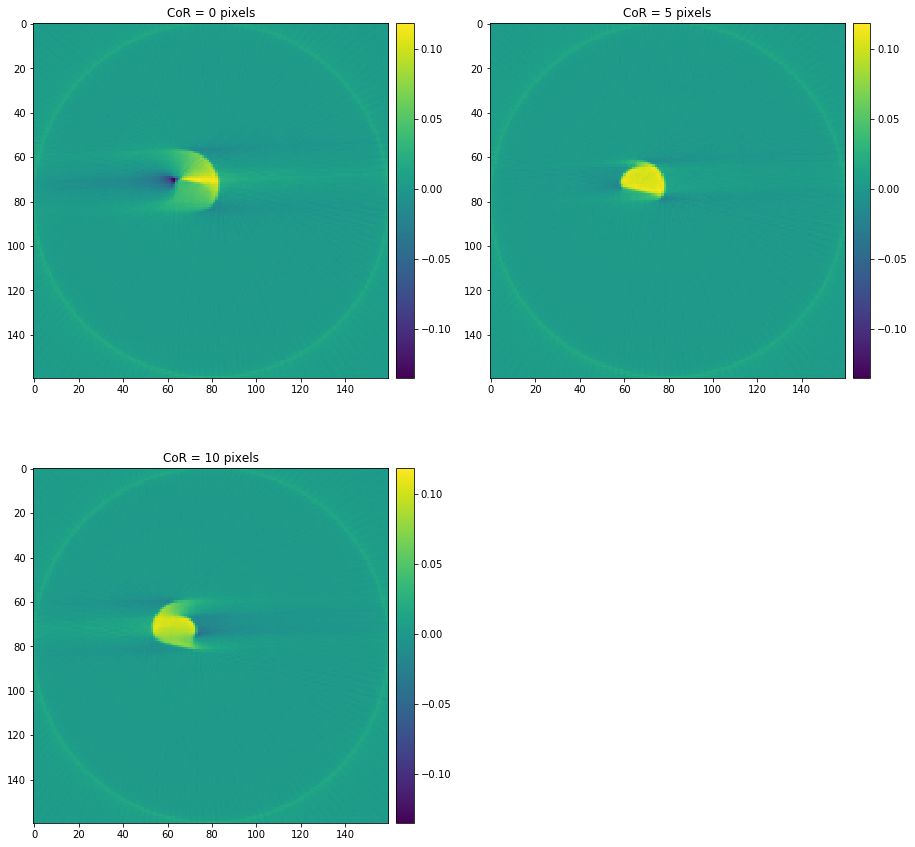

In [5]:
#create empty lists containers for the output
title = []
results = []

#pick a slice to reconstruct
slice_num = 67

#create a new dataset that is just single slice of the data
data_slice =  data.subset(vertical=slice_num)

#convert the angles from degrees to radians for ASTRA
data_slice.geometry.angles = data.geometry.angles * np.pi /180.

# Create Acquisition Geometry
ag = data_slice.geometry.clone()

# Create Image Geometry
ig = ImageGeometry(voxel_num_x=ag.pixel_num_h, voxel_num_y=ag.pixel_num_h )

#pick some values of Centre of rotation offset to compare
offset_list = [0,5,10]

for shift in offset_list:
   
    #translate the acquisition data
    data_shifted = ag.allocate()  
    scipy.ndimage.interpolation.shift(data_slice.as_array(), (0,-shift), output = data_shifted.as_array(), order=1,mode='nearest')
    
    #Perform a fast reconstruction of the slice using FBP
    fbp = FBP(ig, ag, device='gpu')
    fbp.set_input(data_shifted)
    FBP_output = fbp.get_output()  

    title.append("CoR = %s pixels" % shift)
    results.append(FBP_output.as_array()[:,:])

#plot the results    
plotter2D(results,title,fix_range=True)

### Use processors to pre-proccess the data

CIL gives you access to some commonly needed data processors including:
- `Normalizer()` normalises AcquisitionData based on the instrument reading with and without incident photons or neutrons
- `Resizer()` allows you to crop or bin the data in any dimension
- `CenterOfRotationFinder()` finds the center of rotation in a parallel beam dataset (credit: Nghia Vo)

The processors are called in the following way:<br>
>processor_instance = Processor(set_up_parameters)<br>
>processor_instance.set_input(data_in)<br>
>data_out = processor_instance.get_output()<br>

#### Use CenterOfRotationFinder()

We can use `CentreOfRotationFinder()` to locate the Centre of Rotation in a parallel beam dataset. The output is in pixels at the detector.

**ToDo: show diagram** 

In [6]:
# initialise the processsor
cor = CenterOfRotationFinder()

In [7]:
# set the input data
cor.set_input(data)

In [8]:
# get the output data
center_of_rotation = cor.get_output()

In [9]:
print("Centre of rotation at x = ", center_of_rotation)
shift = (center_of_rotation - data.shape[2]/2)
print("Centre of rotation - detector centre = ", shift, " pixels")

Centre of rotation at x =  86.25
Centre of rotation - detector centre =  6.25  pixels


Does this agree with what you saw in Excercise 1?

Now we can correct the acquisition data for the centre of rotation offset above. We do this using a scipy function that shifts and interpolates the data. You could also crop or pad the data to correct for the offset. 

In [10]:
#allocate the memory
data_centred = data.geometry.allocate()
#use scipy to do a translation and interpolation of each projection image
shifted = scipy.ndimage.interpolation.shift(data.as_array(), (0,0,-shift), order=3,mode='nearest')
data_centred.fill(shifted)

In [11]:
#view the data set
islicer(data_centred, direction=0, minmax=(0,3))

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=90)

<span style="color:red;font-size:larger">**Exercise 2:**</span> Process the corrected data `data_centred` with  CentreOfRotationFinder() and convince yourself it's now close to the centre of the detector.

Remember processors are used as:
>processor_instance = Processor(set_up_parameters)<br>
>processor_instance.set_input(data_in)<br>
>data_out = processor_instance.get_output()<br>

In [12]:
# initialise the processsor

# set the input data

# get the output data
center_of_rotation =

print("Centre of rotation at x = ", center_of_rotation)
shift = (center_of_rotation - data_centred.shape[2]/2)
print("Centre of rotation - detector centre = ", shift, " pixels")

SyntaxError: invalid syntax (<ipython-input-12-51069f1f0e02>, line 6)

#### Resizer()
`Resizer(roi, binning)`

Resizer() is a processor used to crop or bin the data.

To crop the data pass the optional region of interest parameter `roi`. This is a list where each element defines the behaviour along one dimension. To crop along an axis pass a tuple containing the start and end coordinates of the crop `roi=[-1,-1,(index0, index1)]` will crop the data between index0 and index1 in dimension 2.

To bin the data in any dimension pass an optional paramer `binning`. This is a list with the number of pixels to bin in each dimension `binning = [1, 1, 2]` will bin the data in blocks of 2 in dimension 2.

In [13]:
print(data_centred)

Number of dimensions: 3
Shape: (91, 135, 160)
Axis labels: {0: 'angle', 1: 'vertical', 2: 'horizontal'}



In [14]:
#define the region of interest
roi_crop = [-1,(1,data_centred.shape[1]),-1]
bins = [1, 1, 1]

In [15]:
#initialise the processsor
resizer = Resizer(roi=roi_crop, binning=bins)

In [16]:
#set the input data
resizer.set_input(data_centred)

In [17]:
#get the output data
data_reduced = resizer.get_output()

In [18]:
#Note the acquistion geometry has also been modified
print(data_reduced)
slicer1 = islicer(data_centred, direction=0)
slicer2 = islicer(data_reduced, direction=0)
link_islicer(slicer1,slicer2)

Number of dimensions: 3
Shape: (91, 134, 160)
Axis labels: {0: 'angle', 1: 'vertical', 2: 'horizontal'}



interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

### Set up the data ready for ASTRA

In order to use the ASTRA projectors we need to manipulate the data in to the form the ASTRA projectors expect.

In 3D geomtery we need the data in the form `['vertical','angle','horizontal']`, which doesn't match the DLS dataset.

In [19]:
print(data_reduced.dimension_labels)

{0: 'angle', 1: 'vertical', 2: 'horizontal'}


We can use `AcquisitionData.subset()` to return an ordered subset of the AcquisitionData and regenerates the geometry.

In [20]:
data_processed = data_reduced.subset(dimensions=['vertical','angle','horizontal'])
print(data_reduced)
print(data_processed)

Number of dimensions: 3
Shape: (91, 134, 160)
Axis labels: {0: 'angle', 1: 'vertical', 2: 'horizontal'}

Number of dimensions: 3
Shape: (134, 91, 160)
Axis labels: {0: 'vertical', 1: 'angle', 2: 'horizontal'}



ASTRA also requires the of projection angles to be in radians. DLS strores their angular data in degrees so we need to convert them.

In [21]:
#convert the angles to radians
if data_processed.geometry.angle_unit == 'degree':
    data_processed.geometry.angle_unit = 'radian'
    data_processed.geometry.angles = data_reduced.geometry.angles * np.pi /180.

In [22]:
#look at the acquisition data
islicer(data_processed, direction=1)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=90)

### Setting up the 3D reconstruction

#### Set up the 3D Acquistion geometry
In the 2D example we used:<br>
`ag = AcquisitionGeometry(geom_type='parallel', dimension='2D', angles=angles, pixel_num_h=number_pixels_x)`<br>

For 3D we need to change the dimension description to ` dimension='3D'`, and pass the number of vertical pixels as `pixel_num_v`<br>

However we've been using the acquistion geometry throughout this notebook so we don't need to redefine it.

In [23]:
# Create Acquisition Geometry
ag = data_processed.geometry.clone()

#### Set up the 3D Image geometry
In the 2D example we used:<br>
`ig = ImageGeometry(voxel_num_x = num_voxels_xy, voxel_num_y = num_voxels_xy)`

For a 3D reconstruction we also need to pass the number of voxels we want in the $z$-direction as `voxel_num_z`. We can also set the voxel size to be equal to the detector pixel size.

In [24]:
# Create Image Geometry
ig = ImageGeometry(voxel_num_x=ag.pixel_num_h,
                   voxel_num_y=ag.pixel_num_h, 
                   voxel_num_z=ag.pixel_num_v,
                   voxel_size_x=ag.pixel_size_h,
                   voxel_size_y=ag.pixel_size_h,
                   voxel_size_z=ag.pixel_size_v)

#### Set up the projector

In the 2D example we used the ASTRA projector:<br>
`'AstraProjectorSimple(volume_geometry, sinogram_geometry, device)`

Now we need to use ASTRA's 3D projector (note this projector is GPU only)<br>
`AstraProjector3DSimple(volume_geometry, sinogram_geometry)`

In [25]:
A = AstraProjector3DSimple(ig, ag)

### Reconstruct using Filtered Back Projection

Reconstruct the data set using the FBP processor from ASTRA

`from ccpi.astra.processors import FBP`

We Run this in the same way as the processors introduced above.

In [26]:
#Initialise the processor
fbp = FBP(ig, ag, device='gpu')
#set the input
fbp.set_input(data_processed)
#Run the procesor
FBP_output = fbp.get_output()
#plot the results
islicer(FBP_output, direction=0)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=133), Output()), _dom_c…

IntSlider(value=0, continuous_update=False, description='x', max=133)

### Reconstruct using Tikhonov with gradient regularisation

Now we have the acquisition data in good shape it's time to set up the reconstruction. We'll once again work through the Tikhonov example, but as we go we'll modify it to work with the 3D dataset.

Recall we are solving:
$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\tilde{A} u - \tilde{b}\end{Vmatrix}^2_2$$



with, $\tilde{A} = \binom{A}{\alpha L}$ and, $\tilde{b} = \binom{b}{0}$

where,
- $u$ is the unknown image to be solved for

- $A$ is the projection operator

- $\alpha$ is the regularisation parameter

- $L$ is a regularisation operator

- $b$ is the acquired data



set up the block operator $\tilde{b}$

We'll again use the `Gradient()` operator. Its domain is specified by the image geometry so the code doesn't need changing.

In [34]:
L = Gradient(ig)

alpha = 10
operator_block = BlockOperator(A, alpha * L)

Set up the block data container, $\tilde{b}$

In [35]:
zero_data = L.range_geometry().allocate(0)
data_block = BlockDataContainer(data_processed,zero_data )

Run CGLS as before, passing the BlockOperator and BlockDataContainer

In [36]:
# setup CGLS with the Block Operator and Block DataContainer
x_init = ig.allocate(0)      
cgls_tikhonov = CGLS(x_init=x_init, operator=operator_block, data=data_block, update_objective_interval = 10)
cgls_tikhonov.max_iteration = 1000

CGLS setting up
CGLS configured


In [37]:
# run the algorithm
cgls_tikhonov.run(100)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.03292e+06
       10       1000         0.136          1.37189e+05
       20       1000         0.133          1.81485e+03
       30       1000         0.134          1.67856e+03
       40       1000         0.138          1.66582e+03
       50       1000         0.140          1.66299e+03
       60       1000         0.140          1.66252e+03
       70       1000         0.140          1.66239e+03
       80       1000         0.141          1.66238e+03
       90       1000         0.140          1.66238e+03
Tolerance is reached: 1e-06


Display the results as a stack of 2D slices

In [38]:
CGLS_tikhonov_output = cgls_tikhonov.get_output()

islicer(CGLS_tikhonov_output, direction=0)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=133), Output()), _dom_c…

IntSlider(value=0, continuous_update=False, description='x', max=133)

### Summary

In [39]:
#compare the outputs
clim_range=(0,0.006)
slicer1=islicer(CGLS_tikhonov_output, direction=0,minmax=clim_range,title='CGLS')
slicer2=islicer(FBP_output, direction=0,minmax=clim_range,title='FBP')

link_islicer(slicer1,slicer2)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=133), Output()), _dom_c…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=133), Output()), _dom_c…

In [40]:
#compare the outputs
clim_range=(0,0.11)
slicer1=islicer(CGLS_tikhonov_output, direction=0,minmax=clim_range,title='CGLS')
slicer2=islicer(FBP_output, direction=0,minmax=clim_range,title='FBP')

link_islicer(slicer1,slicer2)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=133), Output()), _dom_c…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=133), Output()), _dom_c…